In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

c:\Users\itsab\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("CUDA is not available")

CUDA is not available


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
train_dataset = torchvision.datasets.MNIST(root = "./mnist_data", train = True, transform = transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root = "./mnist_data", train = False, transform = transforms.ToTensor())    

In [6]:
input_size = 28*28
hidden_size = 100
num_classes = 10
num_epochs = 6
batch_size = 64
learning_rate = 0.001

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset = train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size=batch_size, shuffle=False)


In [8]:
examples = iter(train_loader)
images, labels = next(examples)
print(images.shape, labels.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


tensor(8)
tensor(4)
tensor(2)
tensor(2)
tensor(2)
tensor(4)


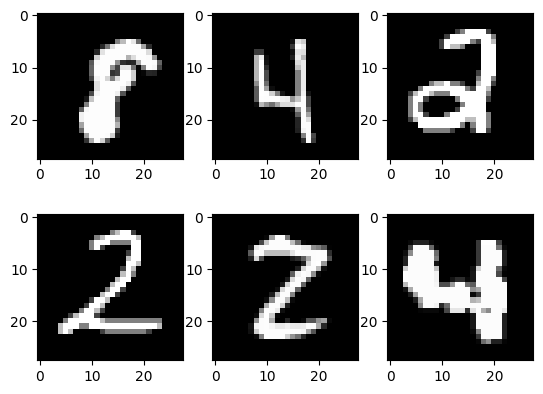

In [10]:
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(images[i][0], cmap="gray")
  print(labels[i])
  
plt.show()

In [12]:
def dim_after_conv(input_dim, kernel_dim, padding, stride):
    dim = (input_dim - kernel_dim + 2*padding) / stride + 1
    return dim


dim_after_conv(28,5,0,1)

24.0

In [14]:
conv1 = nn.Conv2d(1, 6, 5) # 3 input channels(RGB image), 6 output channels, 5x5 kernel
pool = nn.MaxPool2d(2,2)
conv2 = nn.Conv2d(6, 16, 5) # 6 input channels becoz it was the output channel of previous conv layer

print(f"Orginal image batch ( contains 64 images in each batch ) : {images.shape}\n")

x = conv1(images)
print(f"The dimension from the function : {dim_after_conv(input_dim=images.shape[2], kernel_dim= 5, padding= 0, stride=1)}")
print(f"After conv1 : {x.shape}\n")

x = pool(x)
print("When max pooling the dimension is reduced kernel_size times, here it is 2 so halved")
print(f"After pool : {x.shape}\n")

print(f"The dimension from the function : {dim_after_conv(input_dim=x.shape[2], kernel_dim= 5, padding= 0, stride=1)}")
x = conv2(x)
print(f"After conv2 : {x.shape}\n")

x = pool(x)
print("When max pooling the dimension is reduced kernel_size times, here it is 2 so halved")
print(f"After pool : {x.shape}\n")


Orginal image batch ( contains 64 images in each batch ) : torch.Size([64, 1, 28, 28])

The dimension from the function : 24.0
After conv1 : torch.Size([64, 6, 24, 24])

When max pooling the dimension is reduced kernel_size times, here it is 2 so halved
After pool : torch.Size([64, 6, 12, 12])

The dimension from the function : 8.0
After conv2 : torch.Size([64, 16, 8, 8])

When max pooling the dimension is reduced kernel_size times, here it is 2 so halved
After pool : torch.Size([64, 16, 4, 4])



In [18]:
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) # input dimensions is 3 as it is RGB image , 6 output channels is given by us, 5 is the kernel size 5x5
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(6, 16, 5) # input dimensions is 6 as it is the output of previous conv layer, 16 output channels is given by us, 5 is the kernel size 5x5
        
        self.fc1 = nn.Linear((16 * 4 * 4), 120) # The 16 * 5 * 5 is the output of the last conv layer after pooling with 2x2 filter, 
                                                # so it is the input to the fully connected layer so it is flattened
                                                # 120 here can be changed 
                                                
        self.fc2 = nn.Linear(120, 84) # The 84 dimensions can be changed 
        
        self.fc3 = nn.Linear(84, 10) # The 10 comes as there are 10 classes in the CIFAR10 dataset

    def forward(self, x):
        # 1st conv and pooling 
        afterConv1 = self.conv1(x)
        x = self.pool(F.relu(afterConv1))  # -> n, 6, 14, 14
        
        # 2nd conv and pooling
        afterConv2 = self.conv2(x)
        x = self.pool(F.relu(afterConv2))  # -> n, 16, 5, 5
        
        # Flattening
        x = x.view(-1, 16 * 4 * 4)  # -> n, 400
        
        afterFc1 = self.fc1(x)
        x = F.relu(afterFc1)  # -> n, 120
        
        afterFc2 = self.fc2(x)
        x = F.relu(afterFc2)  # -> n, 84
        
        x = self.fc3(x)  # -> n, 10
        
        return x


In [19]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [20]:
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        # print(f"Output shape: {outputs.shape}, Labels shape: {labels.shape}")
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
    

Output shape: torch.Size([64, 10]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10]), Labels shape: torch.Size([64])
Output shape: torch.Size([64, 10]), Labels shape: torch.Size([

In [52]:
classes = test_dataset.classes

In [54]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        # print(f"Predicted : {predicted}, labels : {labels}")
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 10.75 %
Accuracy of 0 - zero: 0.0 %
Accuracy of 1 - one: 0.0 %
Accuracy of 2 - two: 1.3565891472868217 %
Accuracy of 3 - three: 95.24752475247524 %
Accuracy of 4 - four: 0.0 %
Accuracy of 5 - five: 0.0 %
Accuracy of 6 - six: 0.0 %
Accuracy of 7 - seven: 0.0 %
Accuracy of 8 - eight: 10.164271047227926 %
Accuracy of 9 - nine: 0.0 %
